In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as sci
from statsmodels.regression.linear_model import OLS

pd.set_option('float_format', '{:6.5f}'.format)
sns.set(style='ticks')

import warnings
warnings.filterwarnings("ignore")
from statsmodels.regression.linear_model import OLS

In [2]:
df=pd.read_csv('student-mat.csv',sep=';')

In [3]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [4]:
#2
df[['Medu','Fedu','traveltime','studytime','failures','famrel','freetime','goout'
   ,'Dalc','Walc','health']] = df[['Medu','Fedu','traveltime','studytime','failures','famrel','freetime','goout'
   ,'Dalc','Walc','health']].astype(str)

In [5]:
df=pd.get_dummies(df,drop_first = True)

In [6]:
y=pd.DataFrame(df.G3)

In [7]:
del df['G1']
del df['G2']
del df['G3']

In [8]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
sc.fit(df)
X = sc.transform(df)

In [9]:
X=pd.DataFrame(X)

In [198]:
#3
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_validate
loo = LeaveOneOut()
lr=LinearRegression()

In [199]:
from sklearn.linear_model import LogisticRegression
lreg = LogisticRegression()

In [200]:
cross_val = cross_validate(lr,sm.add_constant(X),y,cv=loo,scoring='neg_mean_squared_error',return_train_score=True)
print(-cross_val['test_score'].mean())
print(-cross_val['train_score'].mean())

20.646657832084436
13.479042934398136


In [201]:
mse=pd.DataFrame(columns=['se'])
for train_index,test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model=lr.fit(X_train,y_train)
    se = float((np.array(y_test) - model.predict(X_test)))**2
    mse = mse.append({'se':se}, ignore_index=True)
mse.mean()

se   20.64666
dtype: float64

Looking at the scores I might say that there is probably overfitting because MSE OOS is two times more than MSE IS. However, in reality it is really hard to say something about this fact because we don't have other different models so that we may compare them. We may see different scores (MSE IS) from different models and say quite surely about overfitting.

In [202]:
#4
features = list() # ordered regressors
res_ssr = pd.DataFrame(columns=['reg_th','ssr'])

for num_r in range(len(df.columns)+1):
    if res_ssr is not None:
        for k in range(len(res_ssr)):                        # to find i-th regressor where is min ssr
            if res_ssr['ssr'][k] == res_ssr['ssr'].min():
                features.append(res_ssr['reg_th'][k])
    
    res_ssr=pd.DataFrame(columns=['reg_th','ssr'])
    
    for reg_th in range(len(df.columns)):                # OLS
        if reg_th in features:                           # to avoid having duplicates in the regression 
            continue
        if not features: 
            model_ols = OLS(y, sm.add_constant(X.iloc[:,reg_th]))   #when we try to find the first regressor with min ssr 
            result_ols = model_ols.fit(cov_type='HC0')
            res_ssr = res_ssr.append({'reg_th': reg_th, 'ssr': result_ols.ssr}, ignore_index=True)
        else:
            features.append(reg_th)                                 #adding new regressor to the picked ones before
            model_ols = OLS(y, sm.add_constant(X.iloc[:,features]))
            result_ols = model_ols.fit(cov_type='HC0')
            res_ssr = res_ssr.append({'reg_th': reg_th, 'ssr': result_ols.ssr}, ignore_index=True)
            features.pop()
               

In [203]:
features # the order of the # regressors

[36.0,
 34.0,
 35.0,
 50.0,
 17.0,
 10.0,
 53.0,
 54.0,
 3.0,
 44.0,
 1.0,
 18.0,
 32.0,
 5.0,
 52.0,
 57.0,
 37.0,
 0.0,
 62.0,
 38.0,
 28.0,
 25.0,
 24.0,
 4.0,
 22.0,
 42.0,
 64.0,
 56.0,
 9.0,
 43.0,
 59.0,
 39.0,
 40.0,
 16.0,
 27.0,
 49.0,
 61.0,
 31.0,
 65.0,
 51.0,
 66.0,
 33.0,
 67.0,
 68.0,
 19.0,
 7.0,
 8.0,
 2.0,
 12.0,
 30.0,
 60.0,
 58.0,
 23.0,
 29.0,
 46.0,
 11.0,
 26.0,
 15.0,
 55.0,
 47.0,
 48.0,
 45.0,
 6.0,
 20.0,
 13.0,
 14.0,
 63.0,
 41.0,
 21.0]

In [204]:
mse_cv = pd.DataFrame(columns = ['n_features','mse_is','mse_oos'])

min_mse = None
regr = None
for i in range(len(features)):
    cross_val_m = cross_validate(lr,sm.add_constant(X.iloc[:,features[0:i+1]]),y,
                                 cv=loo,scoring='neg_mean_squared_error',return_train_score=True)
    mse_cv = mse_cv.append({'n_features':len((X.iloc[:,features[0:i+1]]).columns),
                           'mse_is':-cross_val_m.get("train_score").mean(),
                           'mse_oos':-cross_val_m.get("test_score").mean()}, ignore_index=True)
    mse_oos=-cross_val_m.get("test_score").mean()
    
    if min_mse is None:
        min_mse=mse_oos
    elif min_mse>mse_oos:
        min_mse=mse_oos
        regr = i+1


In [207]:
print(regr, 'min_mse:', min_mse)

24 min_mse: 16.577439095228467


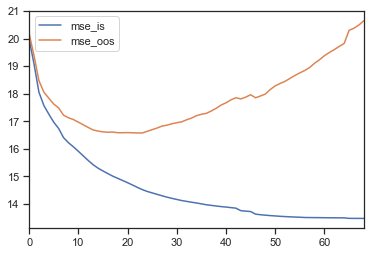

In [208]:
mse_cv[['mse_is','mse_oos']].plot()
plt.show()

Where we see the lowest MSE OOS, there is a good fit relative to the other points. On the left side up to the lowest point, we may consider it probably as underfitting. accroding to the results, on the right it is probably overfitting in the scope of this method.

In [209]:
#5
from sklearn.model_selection import train_test_split
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X, y, random_state=True,
                                                            test_size = 0.2)

In [210]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

mse_ridge = pd.DataFrame(columns = ['n_lymbda','mse_oos'])
lymbda = [i*5 for i in range(1,51)]

for i in lymbda: 
    rid = Ridge(alpha=i)
    rid_res = rid.fit(X_train_5,y_train_5)
    mse_ridge = mse_ridge.append({'n_lymbda': i,'mse_oos': float(((y_test_5 - rid_res.predict(X_test_5))**2).mean())}, ignore_index=True)
    

In [211]:
lass = Lasso(alpha=i)
lass_res = lass.fit(X_train_5,y_train_5)

In [212]:
mse_lasso = pd.DataFrame(columns = ['n_lymbda','mse_oos'])
lymbda_lasso = [.02*i for i in range(1,50)]
for i in lymbda_lasso: 
    lass = Lasso(alpha=i)
    lass_res = lass.fit(X_train_5,y_train_5)
    mse_lasso = mse_lasso.append({'n_lymbda': i,
                                  'mse_oos': float(((y_test_5 - lass_res.predict(X_test_5).reshape(-1,1))**2).mean())}, ignore_index=True )

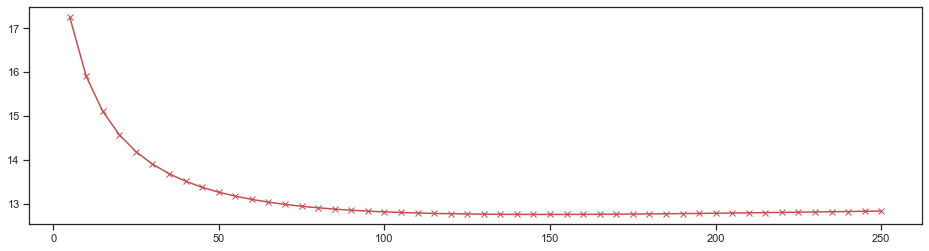

In [213]:
#ridge mse oos

fig, ax = plt.subplots(figsize=(16,4))
ax.plot(mse_ridge['n_lymbda'], mse_ridge['mse_oos'], 'rx', linestyle='solid')
plt.show()

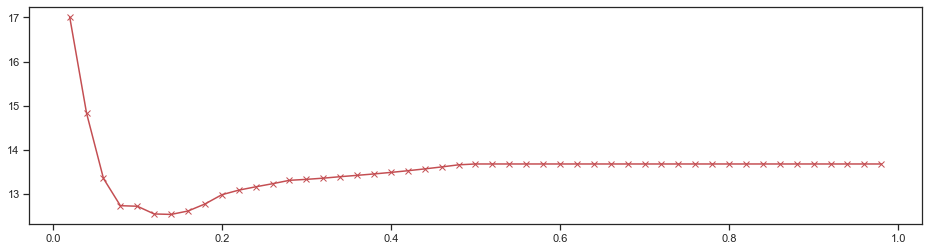

In [214]:
#lasso mse oos

fig, ax = plt.subplots(figsize=(16,4))
ax.plot(mse_lasso['n_lymbda'], mse_lasso['mse_oos'], 'rx', linestyle='solid')
plt.show()

In [215]:
#6
#ridge kfold
from sklearn.model_selection import KFold
min_mse = None
min_lymbda = None
kfold = KFold(n_splits = 10,shuffle=True,random_state=0)
for lymbda in np.linspace(0,60,150):
    ridge_model = Ridge(alpha = lymbda)
    mse_oos = -cross_validate(ridge_model,sm.add_constant(X),y,cv=kfold,
                             scoring='neg_mean_squared_error',return_train_score=True)['test_score'].mean()
    if min_mse is None:
        min_mse=mse_oos
    elif min_mse>mse_oos:
        min_mse=mse_oos
        min_lymbda = lymbda
        
print(min_lymbda,'min_mse:', min_mse)

33.422818791946305 min_mse: 19.061825714012308


In [216]:
#ridge_loo
min_mse = None
min_lymbda = None

for lymbda in np.linspace(0,60,60):
    ridge_model = Ridge(alpha = lymbda)
    mse_oos = -cross_validate(ridge_model,sm.add_constant(X),y,cv=loo,
                             scoring='neg_mean_squared_error',return_train_score=True)['test_score'].mean()
    if min_mse is None:
        min_mse=mse_oos
    elif min_mse>mse_oos:
        min_mse=mse_oos
        min_lymbda = lymbda
        
print(min_lymbda,'min_mse:', min_mse)

32.54237288135593 min_mse: 18.509036340623762


In [217]:
#lasso kfold

min_mse = None
min_lymbda = None

for lymbda in np.linspace(0,1,300):
    lasso_model = Lasso(alpha = lymbda)
    mse_oos = -cross_validate(lasso_model,sm.add_constant(X),y,cv=kfold,
                             scoring='neg_mean_squared_error',return_train_score=True)['test_score'].mean()
    if min_mse is None:
        min_mse=mse_oos
    elif min_mse>mse_oos:
        min_mse=mse_oos
        min_lymbda = lymbda
        
print(min_lymbda,'min_mse:', min_mse)

0.046822742474916385 min_mse: 18.966187953617823


In [223]:
#lasso loo

min_mse = None
min_lymbda = None

for lymbda in np.linspace(0,.1,10):
    lasso_model = Lasso(alpha = lymbda)
    mse_oos = -cross_validate(lasso_model,sm.add_constant(X),y,cv=loo,
                             scoring='neg_mean_squared_error',return_train_score=True)['test_score'].mean()
    if min_mse is None:
        min_mse=mse_oos
    elif min_mse>mse_oos:
        min_mse=mse_oos
        min_lymbda = lymbda
        
print(min_lymbda,'min_mse:', min_mse)

0.05555555555555556 min_mse: 18.434387259364822


In [219]:
#7
from scipy.spatial.distance import mahalanobis
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

In [220]:
knn_mse=pd.DataFrame(columns=['k','mse'])
for k in range(1,31): 
    knn_se=pd.DataFrame(columns=['se'])
    
    for train_index,test_index in loo.split(X):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        knn_model = KNeighborsRegressor(n_neighbors = k, metric = 'mahalanobis', 
                                        metric_params = {'V':np.cov(X_train)}, algorithm = 'brute')
        knn_model_fit = knn_model.fit(X_train,y_train)
        knn_se=knn_se.append({'se':float((np.array(y_test) - knn_model_fit.predict(X_test)))**2},
                             ignore_index=True)
        
    knn_mse = knn_mse.append({'k':k,'mse':knn_se['se'].mean()},ignore_index=True)
        

    

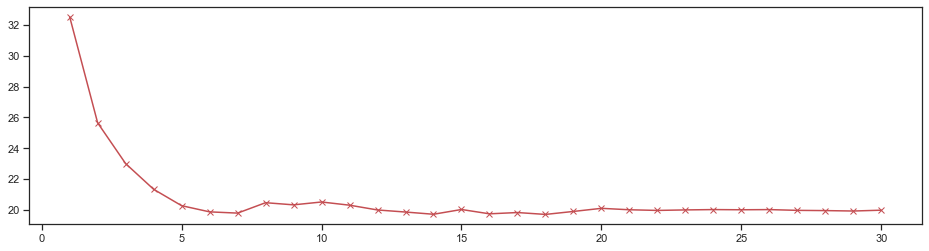

In [221]:
fig, ax = plt.subplots(figsize=(16,4))
ax.plot(knn_mse['k'], knn_mse['mse'], 'rx', linestyle='solid')
plt.show()

k = 17 is the best result in mse oos.

#8

The best performing model if we take into consideration a coefficient mse that is out of sample, then it is a linear regression. I used a forward stepwise technique to order the regressors. Using ordered 24 regressors gives the best result. However, in my personal view, it doesn't mean that it is the best method (linear regression) because there may occur some issues relative to a functional form, overfitting and so on. Linear regression tries to minimize MSE IS but the goal in ML to have the best prediction. In other words, we generally should consider mse oos so there are other methods such as Lasso and Ridge regressions that allow not to overfit on training data. That is why it can be beneficial we might get a better result on test data. My choice is Lasso or Ridge regression. Nevertheless, we might have problems with a functional form because these methods are quite unflexible. According to this problem, KNN regression helps to eliminate this problem to make a model more flexible. Conversely, this method has some dimensional issue if we have many features and not so many observations, therefore, the distance between observations might be large. Thus, this method will perform worse than Ridge or Lasso.
In conclusion, some methods may perform better in different situations, and it is hard to choose which one to use in a particular situation. We have to compare them using particular data so that we can obtain cross-validation scores from these methods and after that, we may say.
If we take this situation, I would choose Lasso or Ridge because there are a large space and little observations. Also, MSE OOS says about this fact.

